### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 16
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [6]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [7]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

m20ire = iretohz(-20)

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [8]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [9]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # mostly used for internal tests, but the exact opposite of the above
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    #sps.zpk2tf(-filterset['deemp'][0]*(10**-10)/2.0, -filterset['deemp'][1]*(10**-10)/2.0, filterset['deemp'][1] / filterset['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        bf = sps.firwin(257, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fcburst'] = filtfft((bf, [1.0]))
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [10]:
# The actual video demodulation code

def dodemod(paramsc, data, usemtf = False, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [11]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9450000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [12]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [13]:
def demod(infile, _start, _end, filterset, usemtf = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen )
            break
    
        tmp = dodemod(filterset, indata, usemtf=usemtf)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    return output

In [14]:
if True: # DD 3.0 beta fantasia example
    params['freq'] = 40.0
    deemp_adj1 = .63
    deemp_adj2 = .525

    params['freq'] = 44.0
    deemp_adj1 = .55
    deemp_adj2 = .55

    
    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 1

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 7

else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

#infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
#infile = open('/home/cpage/erica_44a.raw', 'rb')
#tmp= demod(infile, 50000, 2000000, filterset)

In [15]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [16]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out
    
    

In [17]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(blocklen, dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    filterset['dgap'] = calczc(fakedecode['demod'], 1250, iretohz(-20), 500) - calczc(fakeoutput_emp, 1250, iretohz(-20), 500)
    filterset['dgap_05'] = calczc(fakedecode['demod_05'], 1250, iretohz(-20), 500) - calczc(fakedecode['demod'], 1250, iretohz(-20), 500)

    fdburst_adj = fakedecode['demod_burst'][128:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

In [18]:
dg = calc_demodgaps(filterset)

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [19]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        #endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
        endsync1 = center + np.where(syncf[center:center + scanarea] > .95)[0][-1]
        endsync = endsync1 + np.where(syncf[endsync1:endsync1 + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .6)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        #print(endsync)
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .6)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    #print(lastlinepresync, nextline, presync_eqlen, postsync_eqlen)
    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

#findburstfromsync(rdata['demod_sync'], 190301)

In [20]:
def findsync(output_sync, loc = 0):
    loc = 0

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

    if np.max(output_sync[loc:loc+imglen]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv

    print(np.max(output_sync[loc:loc+imglen]), pregap, postgap)
    
    if pregap >= 3.75:
        firstfield = False
    else:
        firstfield = True
    
    return syncloc, firstfield, nextline

In [21]:
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

def findfirstframe(infile, start = 0):
    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and not firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and firstfield:
            return loc + nextline, data
    
    return None

In [22]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [34]:
def downscale_field(data, lineinfo):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        try:
            scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
            sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)
        except:
            scaled = scale(data, lineinfo[l], lineinfo[l + 1], 910)
            sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

In [24]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [25]:
def calcerr(subset):
    black = np.mean(subset)
    
    subseta = np.abs(subset - black)
    
    peaks = np.where(subseta > 80000)[0]
    toffset = 0
    noffsets = 0

    for p in range(0, len(peaks) - 1):
        if np.abs(subseta[peaks[p]] - subseta[peaks[p + 1]]) < 40000:
            zp = calczc(subset, peaks[p], black)

            if zp is not None:
                #print(peaks[p], subset[peaks[p]] - 8100000, zp, (zp - peaks[p] - 0))

                offset = (zp - peaks[p] - 1)
                toffset += offset
                noffsets += 1
            else:
                offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [140]:
def buildfield(frame, start = 0):
    output = frame['demod']
    output_sync = frame['demod_sync']
    output_lp = frame['demod_05']
    output_burst = frame['demod_burst']

    ilinepx = int(filterset['line_px'])
    
    syncloc1, firstfield, line1 = findsync(frame['demod_sync'][start:start + int(100 * filterset['line_px'])], 0)

    curloc = line1 + start
    print(line1)

    lineinfo = [curloc]
    for i in range(0, 253):
        prevloc = curloc

        curloc += int(filterset['line_px'] * .9)
        offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
        curloc += offset 

        # if the sync detection burst doesn't look good, reuse the last one
        is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
        validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
        if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
            if i < 252:
                print("bad sync", i, curloc)
            curloc = prevloc + (lineinfo[-1] - lineinfo[-2])

    #    print(curloc, output[curloc], output[curloc+8])

        lineinfo.append(curloc)

    crossire = iretohz(-15)

    lineinfo2 = []

    for l in lineinfo:
        zc = calczc(output_lp, l - 5, crossire, 40) 

        if zc is None:
            lineinfo2.append(l)
            continue

        lineinfo2.append(zc - filterset['dgap_05'])
        print(l, zc, output[l], output[l + 1], output[l + 2])

    lineinfo2[0] = lineinfo2[1] - (lineinfo2[2] - lineinfo2[1])
    
    # now for fine sync

    # first pass: check hsyncs and color burst quality.  Any spikes in either will cause
    # the line to be ignored and location interpolated.

    lineinfo_tmp = lineinfo2.copy()
    lineinfo3 = [(lineinfo2[0], lineinfo[1])]
    badburst = np.zeros_like(lineinfo_tmp)
    finalsnr = []

    for l in range(1, len(lineinfo2) - 1):
        # hsync check
        scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
        subset = scaled[850:910]
        if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
            badburst[l] = 1

        # color burst check
        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
        scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
        subset = scaled[5:60]

        #print(l, np.min(subset), np.max(subset))
        if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
            badburst[l] = 1

    # and finer sync
    lineinfo_tmpa = lineinfo2.copy()
    offset = 0

    lineinfo_tmpa[0] = lineinfo_tmpa[1] - (lineinfo_tmpa[2] - lineinfo_tmpa[1])

    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        cut = output_burst[int(lineinfo_tmpa[l])+128:int(lineinfo_tmpa[l])+268].copy()
        cut -= cut.mean()

        #adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (910 / linelen)
        adjpeak = (calczc(cut, np.argmax(cut), 0) + filterset['dgap_burst']) * (910 / linelen)

        target = (np.round((adjpeak - 0) / 2) * 2) + 0

        #offset = (adjpeak - np.floor(adjpeak)) * (linelen / 910)
        prevoffset = offset
        offsets[l] = (adjpeak - target)

        if False:#(np.abs(prevoffset - offset) > 1.6):
            if offset > 0:
                target += 2
            else:
                target -= 2
            offset = adjpeak - target

        print(l, np.argmax(cut), np.max(cut), calczc(cut, np.argmax(cut), 0), adjpeak, target, offsets[l])

    # outlier repair
    for l in range(2, len(lineinfo_tmpa) - 2):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.6) and (np.abs(offsets[l] - offsets[l + 1]) > 1.6):
            print("outlier repair ", l)
            if offsets[l] > 0:
                offsets[l] -= 2
            else:
                offsets[l] += 2
            
    for l in range(1, len(lineinfo_tmpa) - 1):
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offset  * (linelen / 910)) #- filterset['dgap_burst']    
        
    field, sfactor = downscale_field(output, lineinfo_tmpa)
    
    return field, lineinfo_tmpa


In [141]:
infile = open('/home/cpage/ve22_44zonea.raw', 'rb')
#infile = open('/home/cpage/ggv22_44-53999.raw', 'rb')
#infile = open('/home/cpage/erica_44a.raw', 'rb')
needmtf = False

#d, rdata = findfirstframe(infile, 0)
d, rdata = findfirstframe(infile, 1024*1024*200)

# XXX: why 80 lines before what findfirstframe returns???
start = d - int(80 * filterset['line_px'])

data = demod(infile, d - int(80 * filterset['line_px']), d + int(300 * filterset['line_px']), filterset, needmtf)

fs = findsync(data['demod_sync'], 0)
fs

209714688 210072832 358144
209715200 0.999827567955 0.0879805600906
0.999827567955 4.00984967788 3.5070293486
209715200 209745191 False 0.999827567955 0.0879805600906
210385248 210743392 358144
210385760 0.999826329649 0.0878046009108
0.999826329649 3.50984967788 4.00738725841
210385760 210478234 True 0.999826329649 0.0878046009108
210268532 211330764 1062232
0.999826329454 3.50984967788 4.00738725841


(209190, True, 223520)

In [142]:
frame = demod(infile, d - int(20 * filterset['line_px']), d + int(800 * filterset['line_px']), filterset, needmtf)
syncloc1, firstfield, line1 = findsync(frame['demod_sync'][0:int(24 * filterset['line_px'])], 0)

syncloc2, secondfield, line2 = findsync(frame['demod_sync'][int(250 * filterset['line_px']):int(290 * filterset['line_px'])], 0)
syncloc2 += int((250 - 0) * filterset['line_px']) 
line2 += int(250 * filterset['line_px'])

210436172 212727764 2291592
0.999826329649 3.50984967788 4.00738725841
0.999827562369 4.00984967788 3.50738725841


In [143]:
lines_odd, lineinfo_odd = buildfield(frame, 0)

0.999826329649 3.50984967788 4.00738725841
55880
58744 58758.8957096 7786338.87502 7845114.34024 7905632.31024
61541 61555.3668769 7794849.88145 7866169.27518 7939273.7064
64337 64351.5800498 7791520.7711 7854850.95277 7918752.54177
67133 67148.4111179 7771147.04568 7832815.40232 7896923.34436
69930 69944.2105238 7795767.61686 7861387.04819 7933202.02734
72726 72740.7003889 7759506.17554 7823585.92818 7898761.12738
75522 75537.2082115 7739821.96647 7802651.78225 7874644.19341
78319 78333.3499096 7794875.19842 7859267.2394 7930632.36062
81115 81129.7590265 7782497.09998 7852980.48015 7925071.42076
83911 83925.8123861 7765453.89255 7833496.49749 7906255.20154
86707 86722.0942471 7787470.03168 7851868.08556 7913987.98709
89503 89518.4771772 7748702.64778 7820149.11658 7893435.86847
92299 92314.4400054 7753733.30802 7817278.38812 7881822.897
95096 95110.4270741 7790849.88871 7854259.29513 7923103.22203
97892 97906.4261849 7781685.00724 7845925.78043 7917888.50906
100688 100702.768433 77752

1 82 151750.64097 85.2408547586 27.7820131823 28.0 -0.217986817729
2 88 146011.374667 90.7470021792 29.5764978822 30.0 -0.423502117789
3 94 147753.506598 97.3478777203 31.7176788903 32.0 -0.282321109711
4 100 148716.269289 102.779057849 33.4971684481 34.0 -0.502831551868
5 94 145272.890226 97.0278300004 31.6174027329 32.0 -0.382597267124
6 88 147330.965435 91.1420682986 29.7019384262 30.0 -0.298061573832
7 94 146264.165456 96.7136215113 31.519080968 32.0 -0.480919031997
8 100 145183.437821 103.084014579 33.5891031472 34.0 -0.410896852803
9 94 150650.767932 97.3200280149 31.7174370767 32.0 -0.282562923325
10 88 142759.333933 91.2641859428 29.7440795844 30.0 -0.255920415594
11 106 150995.970758 108.991596857 35.5118653715 36.0 -0.488134628462
12 100 145604.508229 102.819520278 33.5083798373 34.0 -0.491620162654
13 94 155997.004364 97.0543491045 31.6317195012 32.0 -0.368280498761
14 100 150043.137515 103.111671599 33.603030057 34.0 -0.39696994303
15 94 151404.278741 97.1009322224 31.64286

238 88 148681.054877 91.0537985846 29.6792943717 30.0 -0.320705628325
239 94 147453.120877 97.3571920382 31.7288581131 32.0 -0.271141886944
240 88 149182.31401 91.2744054963 29.7522932141 30.0 -0.247706785873
241 82 149429.26855 85.3223288948 27.8059554175 28.0 -0.194044582486
242 100 146481.444473 102.795113835 33.5047359306 34.0 -0.495264069372
243 94 149334.674744 96.8543543441 31.5628215654 32.0 -0.437178434555
244 88 153158.587708 90.8184426381 29.5984585158 30.0 -0.401541484219
245 94 154505.993942 97.2513939011 31.6934947544 32.0 -0.306505245627
246 88 147432.597425 91.0917223874 29.6899143215 30.0 -0.310085678523
247 81 146840.951463 84.2605881422 27.4652280045 28.0 -0.534771995543
248 100 147339.132095 102.740400474 33.4842812636 34.0 -0.515718736407
249 94 150149.735829 97.045823371 31.6211886767 32.0 -0.378811323347
250 88 152229.950393 91.0526673676 29.6741272934 30.0 -0.325872706622
251 81 142507.864751 84.2528632047 27.4651371372 28.0 -0.534862862772
252 100 147465.936347

In [144]:
start = syncloc2 - int(15 * filterset['line_px'])
findsync(frame['demod_sync'][start:start + int(100 * filterset['line_px'])], 0)

0.999827562369 4.00984967788 3.50738725841


(41910, False, 56239)

In [145]:
lines_even, lineinfo_even = buildfield(frame, start)

0.999827562369 4.00984967788 3.50738725841
56239
791044 791059.204327 7771921.04574 7836445.46044 7905743.01747
793841 793855.394018 7775690.55077 7836353.44461 7903549.59374
796637 796652.451924 7752755.9011 7810628.28141 7874133.83015
799434 799449.099422 7764064.40089 7828049.62884 7899439.18578
802230 802245.710158 7743593.07788 7807316.13574 7873655.78448
805027 805042.527297 7740217.19752 7807370.65716 7882284.07996
807824 807839.029724 7771945.61403 7846528.01246 7919660.11462
810621 810636.435537 7777272.94886 7860259.59509 7945971.7769
813418 813433.014215 7795089.64377 7856427.41561 7922476.95657
816215 816229.818457 7795826.22927 7871990.11464 7949496.76598
819011 819025.886933 7787088.23334 7848148.56553 7911649.16704
821808 821822.976771 7772054.69053 7835859.5321 7905822.77848
824604 824619.788546 7738759.55862 7799409.45158 7868444.14589
827401 827416.619696 7754533.88795 7811345.51285 7872890.22885
830198 830213.668125 7744668.51219 7802297.7497 7866780.49761
832995 833

1 81 148003.998256 84.2250579378 27.4542260027 28.0 -0.545773997292
2 88 145898.058005 90.9050523558 29.6189858946 30.0 -0.381014105419
3 94 148968.876178 96.7190409154 31.5151438591 32.0 -0.484856140935
4 87 143834.464151 90.173821539 29.3857838573 30.0 -0.614216142718
5 94 147164.038713 96.9843515129 31.5995563759 32.0 -0.400443624071
6 87 148727.017137 90.4339108068 29.471556706 30.0 -0.528443294045
7 81 148660.529874 84.1683476809 27.4238428486 28.0 -0.57615715135
8 87 145802.954466 89.8935269706 29.2949135264 30.0 -0.705086473628
9 93 149525.17886 95.8591225484 31.2335848154 32.0 -0.766415184637
10 87 145884.91936 90.3762376979 29.4573605858 30.0 -0.542639414165
11 94 154388.831454 97.3832327374 31.7262468942 32.0 -0.273753105849
12 99 148912.236358 102.234322023 33.307802434 34.0 -0.692197566008
13 94 150236.501412 96.9685671303 31.5942623484 32.0 -0.405737651623
14 100 146919.438163 102.92431945 33.5294701078 34.0 -0.470529892213
15 94 151994.225945 96.8254385142 31.546237246 32

225 94 148779.000947 96.7652248705 31.5226645281 32.0 -0.477335471911
226 87 148944.032255 89.9732238585 29.3132385965 30.0 -0.686761403537
227 94 145023.29013 96.699426873 31.5027909229 32.0 -0.497209077106
228 88 147237.690365 90.8380336914 29.590077864 30.0 -0.409922136002
229 81 150979.167366 84.1461292556 27.419110515 28.0 -0.580889485005
230 100 143455.042839 102.748514249 33.4704855533 34.0 -0.529514446712
231 94 146456.374266 96.952382173 31.5827150303 32.0 -0.417284969691
232 87 159643.145485 89.9514466604 29.3096131749 30.0 -0.690386825132
233 93 143571.697796 96.3385016753 31.3865008831 32.0 -0.613499116897
234 87 147047.150613 90.2520027559 29.4037507705 30.0 -0.596249229492
235 94 146586.271452 96.699801169 31.505014355 32.0 -0.494985645047
236 100 148438.937637 102.770599322 33.4751149441 34.0 -0.524885055938
237 94 151599.228724 96.8469635826 31.5568256884 32.0 -0.443174311622
238 100 147907.815398 102.969160055 33.5446735089 34.0 -0.455326491124
239 94 145132.364378 96.

(230230,)
uint8 (253, 910) (253, 910)


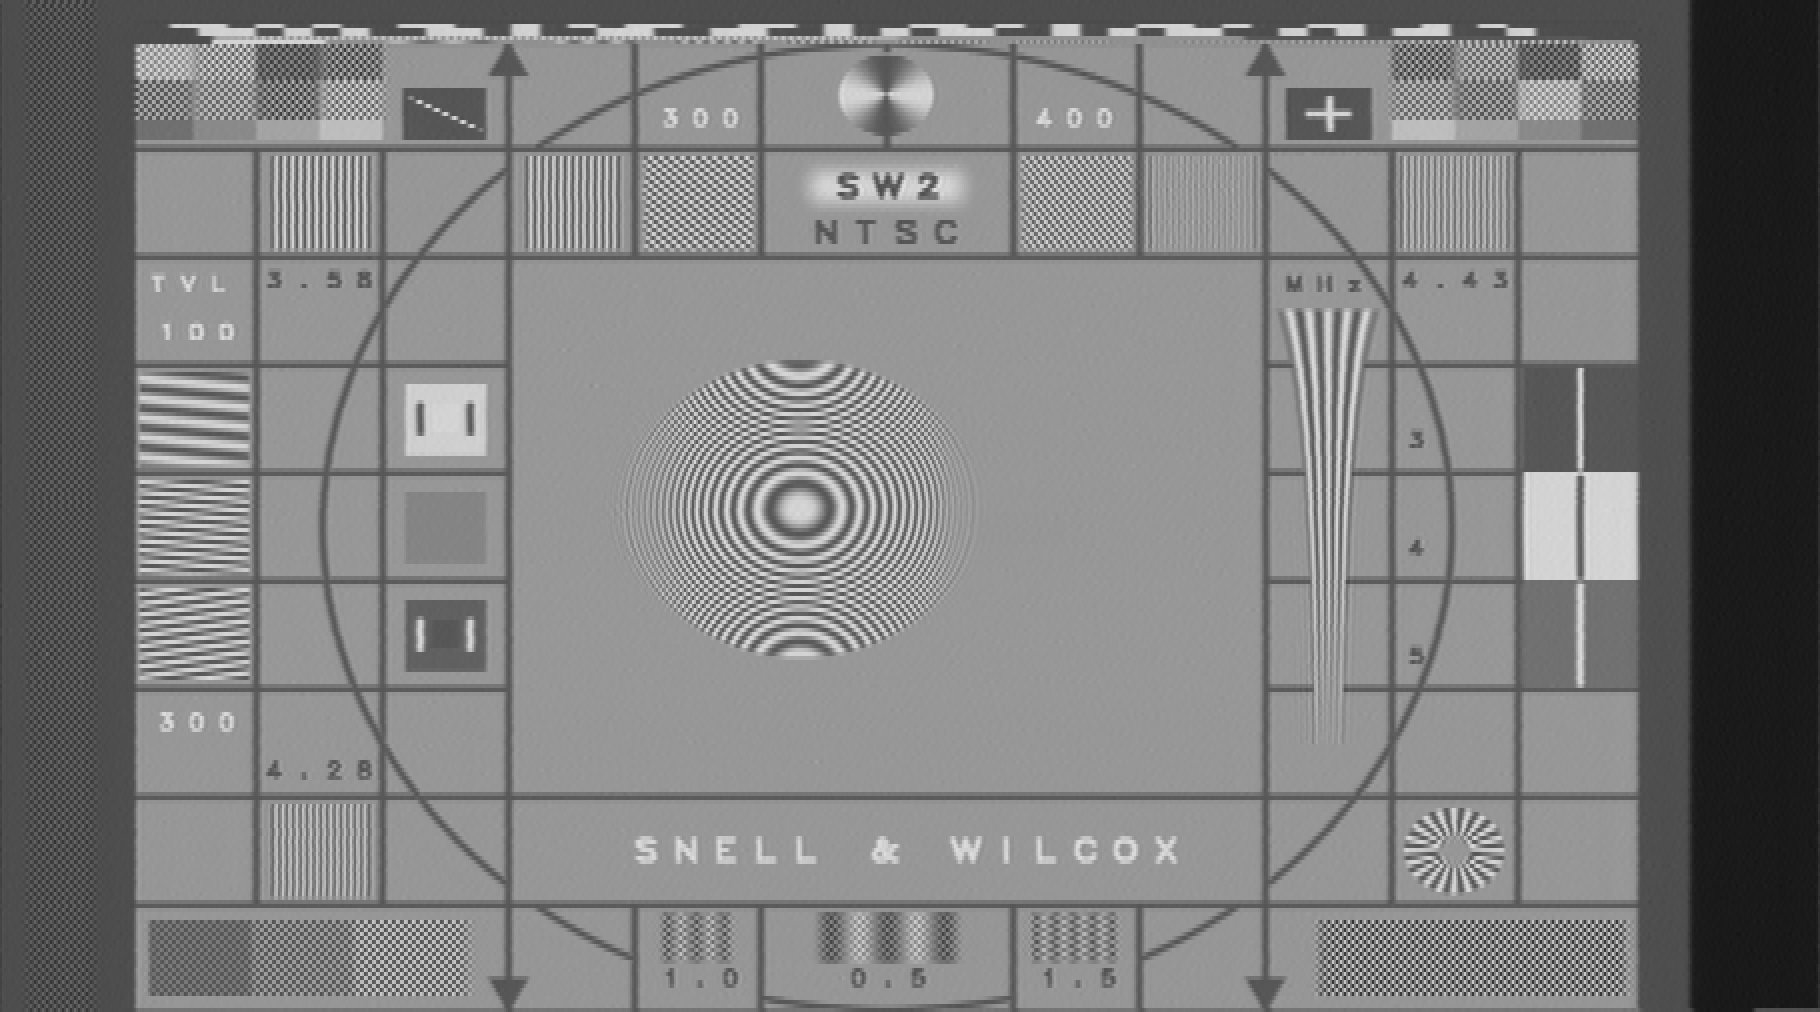

In [147]:
reduced = (lines_odd - minn) / hz_ire_scale
lines16a = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16a, 910, len(lineinfo)-1, hscale=2, vscale=4)

(230230,)
uint8 (253, 910) (253, 910)


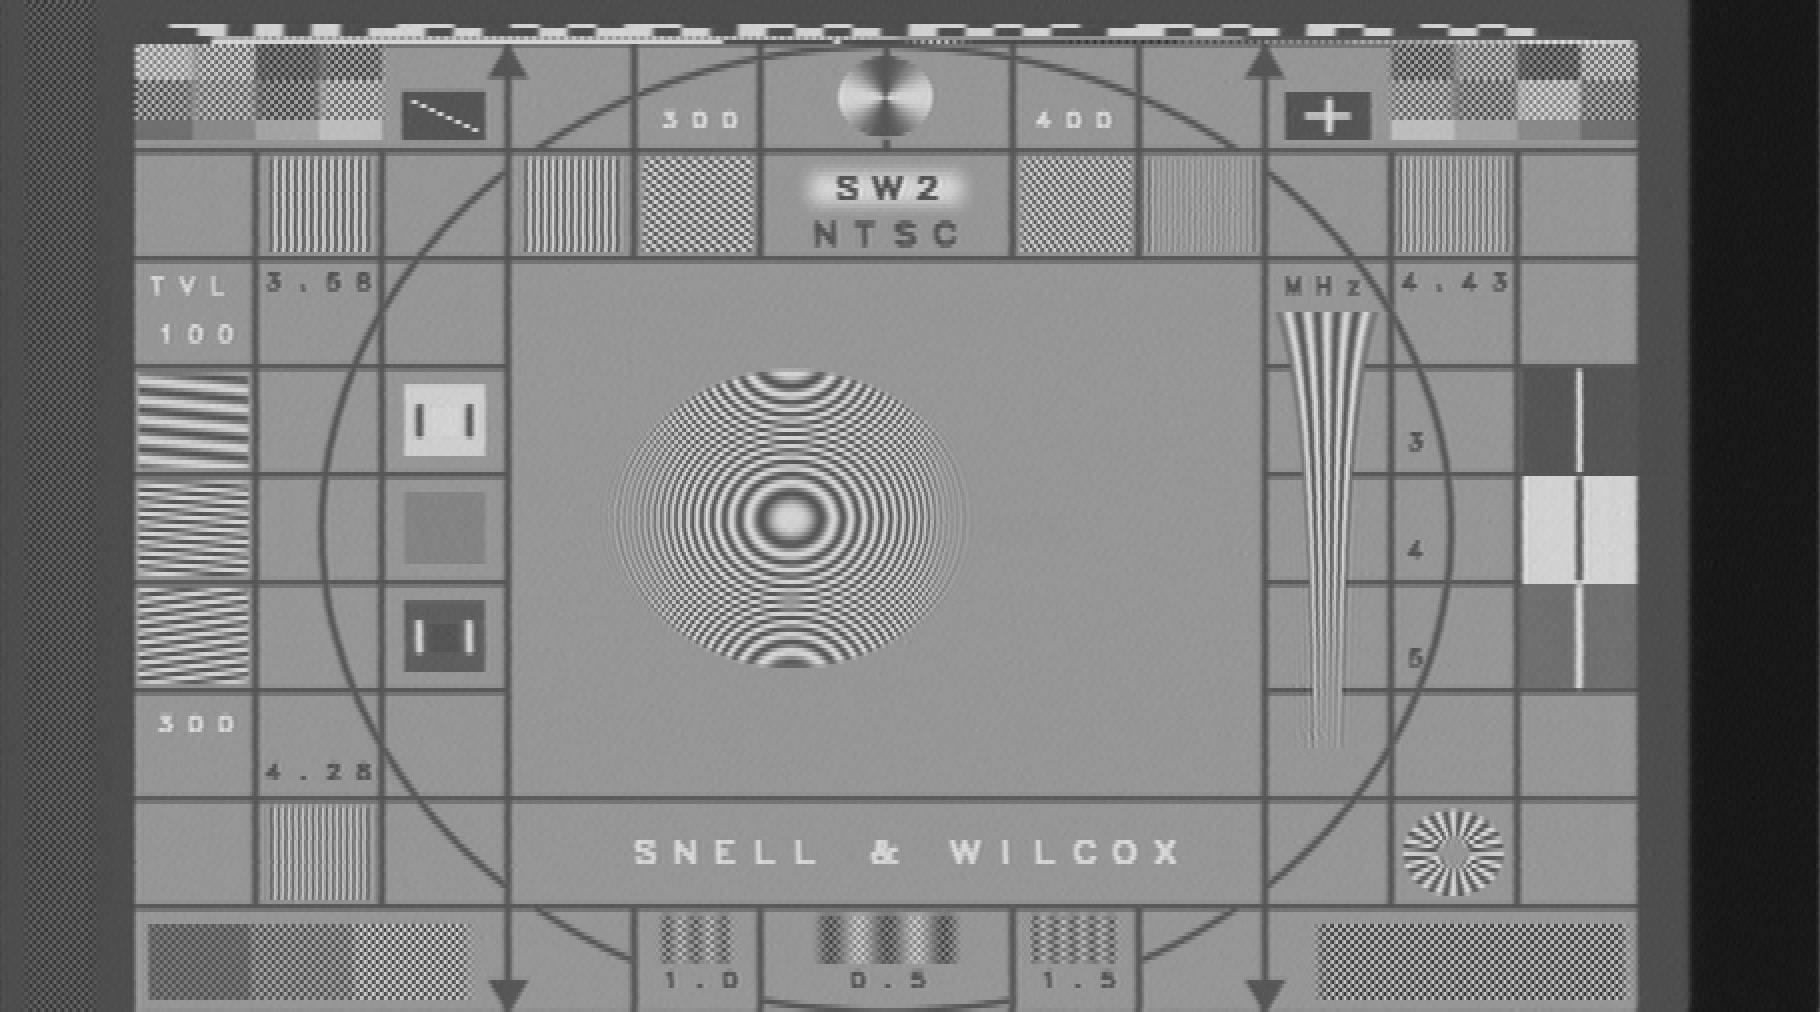

In [148]:
reduced = (lines_even - minn) / hz_ire_scale
lines16a = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16a, 910, len(lineinfo)-1, hscale=2, vscale=4)

In [149]:
combined = np.zeros((910 * 506), dtype=np.double)
for i in range(0, 505, 2):
    combined[((i + 0) * 910):((i + 1) * 910)] = lines_even[(i // 2) * 910: ((i // 2) + 1) * 910]
    combined[((i + 1) * 910):((i + 2) * 910)] = lines_odd[(i // 2) * 910: ((i // 2) + 1) * 910]

(460460,)
uint8 (506, 910) (506, 910)


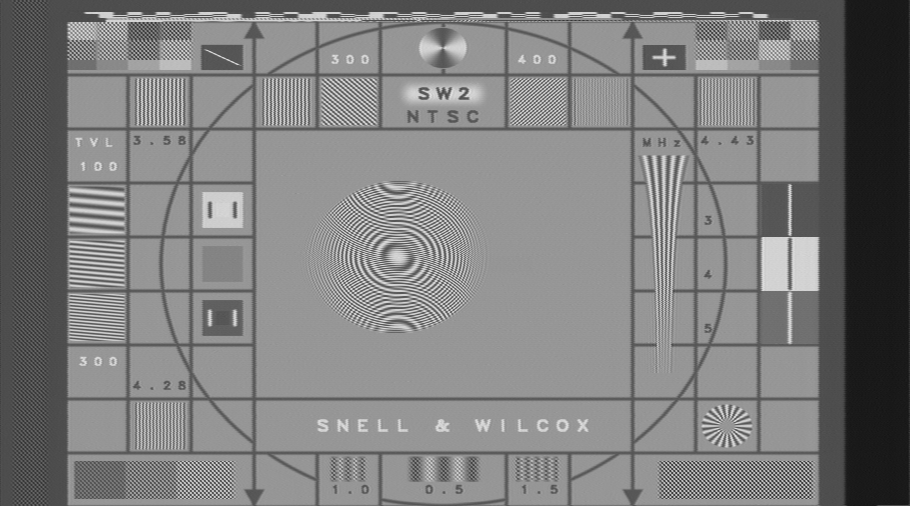

In [150]:
reduced = (combined - minn) / hz_ire_scale
lines16a = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16a, 910, 506, hscale=1, vscale=1)

In [154]:
lineinfo_tmpa = lineinfo2.copy()

offset = 0

lineinfo_tmpa[0] = lineinfo_tmpa[1] - (lineinfo_tmpa[2] - lineinfo_tmpa[1])

for l in range(1, len(lineinfo_tmpa) - 1):
    if badburst[l]:
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
        continue

    linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
    cut = output_burst[int(lineinfo_tmpa[l])+128:int(lineinfo_tmpa[l])+268].copy()
    cut -= cut.mean()

    #adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (910 / linelen)
    adjpeak = (calczc(cut, np.argmax(cut), 0) + filterset['dgap_burst']) * (910 / linelen)

    target = (np.round((adjpeak - 1) / 2) * 2) + 1

    #offset = (adjpeak - np.floor(adjpeak)) * (linelen / 910)
    prevoffset = offset
    offset = (adjpeak - target)

    if False:#(np.abs(prevoffset - offset) > 1.6):
        if offset > 0:
            target += 2
        else:
            target -= 2
        offset = adjpeak - target

    print(l, np.argmax(cut), np.max(cut), calczc(cut, np.argmax(cut), 0), adjpeak, target, offset)

    lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offset  * (linelen / 910)) #- filterset['dgap_burst']

1 88 148238.985124 90.9502404879 29.6398234336 29.0 0.639823433557
2 81 141747.615998 84.3162755364 27.482767929 27.0 0.482767928966
3 88 146550.899462 90.8051844275 29.5959420684 29.0 0.595942068432
4 94 147576.950473 97.3843178501 31.7329795402 31.0 0.732979540162
5 100 142250.370762 102.843667445 33.5110901156 33.0 0.51109011557
6 94 152258.549196 97.1321096673 31.6516818342 31.0 0.651681834246
7 87 150279.555962 90.2601219361 29.4196959545 29.0 0.419695954544
8 94 145377.760174 96.6993221415 31.5110964406 31.0 0.511096440603
9 100 147534.790731 103.082425827 33.5908001424 33.0 0.590800142413
10 94 147025.09242 97.135454447 31.6550399196 31.0 0.655039919554
11 87 147003.925215 90.1699826157 29.3906392532 29.0 0.390639253235
12 106 151043.194261 108.863220864 35.4664597035 35.0 0.466459703477
13 100 147324.132162 102.703143144 33.4693633597 33.0 0.469363359714
14 106 146336.521509 109.16552223 35.5743318486 35.0 0.574331848644
15 100 149577.861827 102.954180583 33.5520114328 33.0 0.5

In [155]:
snrold = []
snrnew = []
for l in range(1, len(lineinfo2) - 2):
    scaled1 = scale(output, lineinfo2[l], lineinfo2[l + 1], 910) # 1092 is 1.2x 910
    scaled2 = scale(output, lineinfo2[l + 1], lineinfo2[l + 2], 910) # 1092 is 1.2x 910
    
    a1 = scaled1[10:50] - np.mean(scaled1[10:50])
    a2 = scaled2[10:50] - np.mean(scaled2[10:50])
    snrold.append(calcsnr((a1 + a2) + 8100000))

    scaled1 = scale(output, lineinfo_tmpa[l], lineinfo_tmpa[l + 1], 910) # 1092 is 1.2x 910
    scaled2 = scale(output, lineinfo_tmpa[l + 1], lineinfo_tmpa[l + 2], 910) # 1092 is 1.2x 910
    
    a1 = scaled1[10:50] - np.mean(scaled1[10:50])
    a2 = scaled2[10:50] - np.mean(scaled2[10:50])
    snrnew.append(calcsnr((a1 + a2) + 8100000))
    #a2 = scaled1[0:80] + scaled2[0:80]
    #break
    
    #print(l, offset, calczc(scaled1, 35, 8100000), calczc(scaled, 35, 8100000))
    if snrold[-1] - 3 > snrnew[-1]:
        print(l, snrold[-1], snrnew[-1])


In [156]:
np.mean(snrold), np.mean(snrnew)

(33.366553015399127, 34.578302596745594)

(230230,)
uint8 (253, 910) (253, 910)


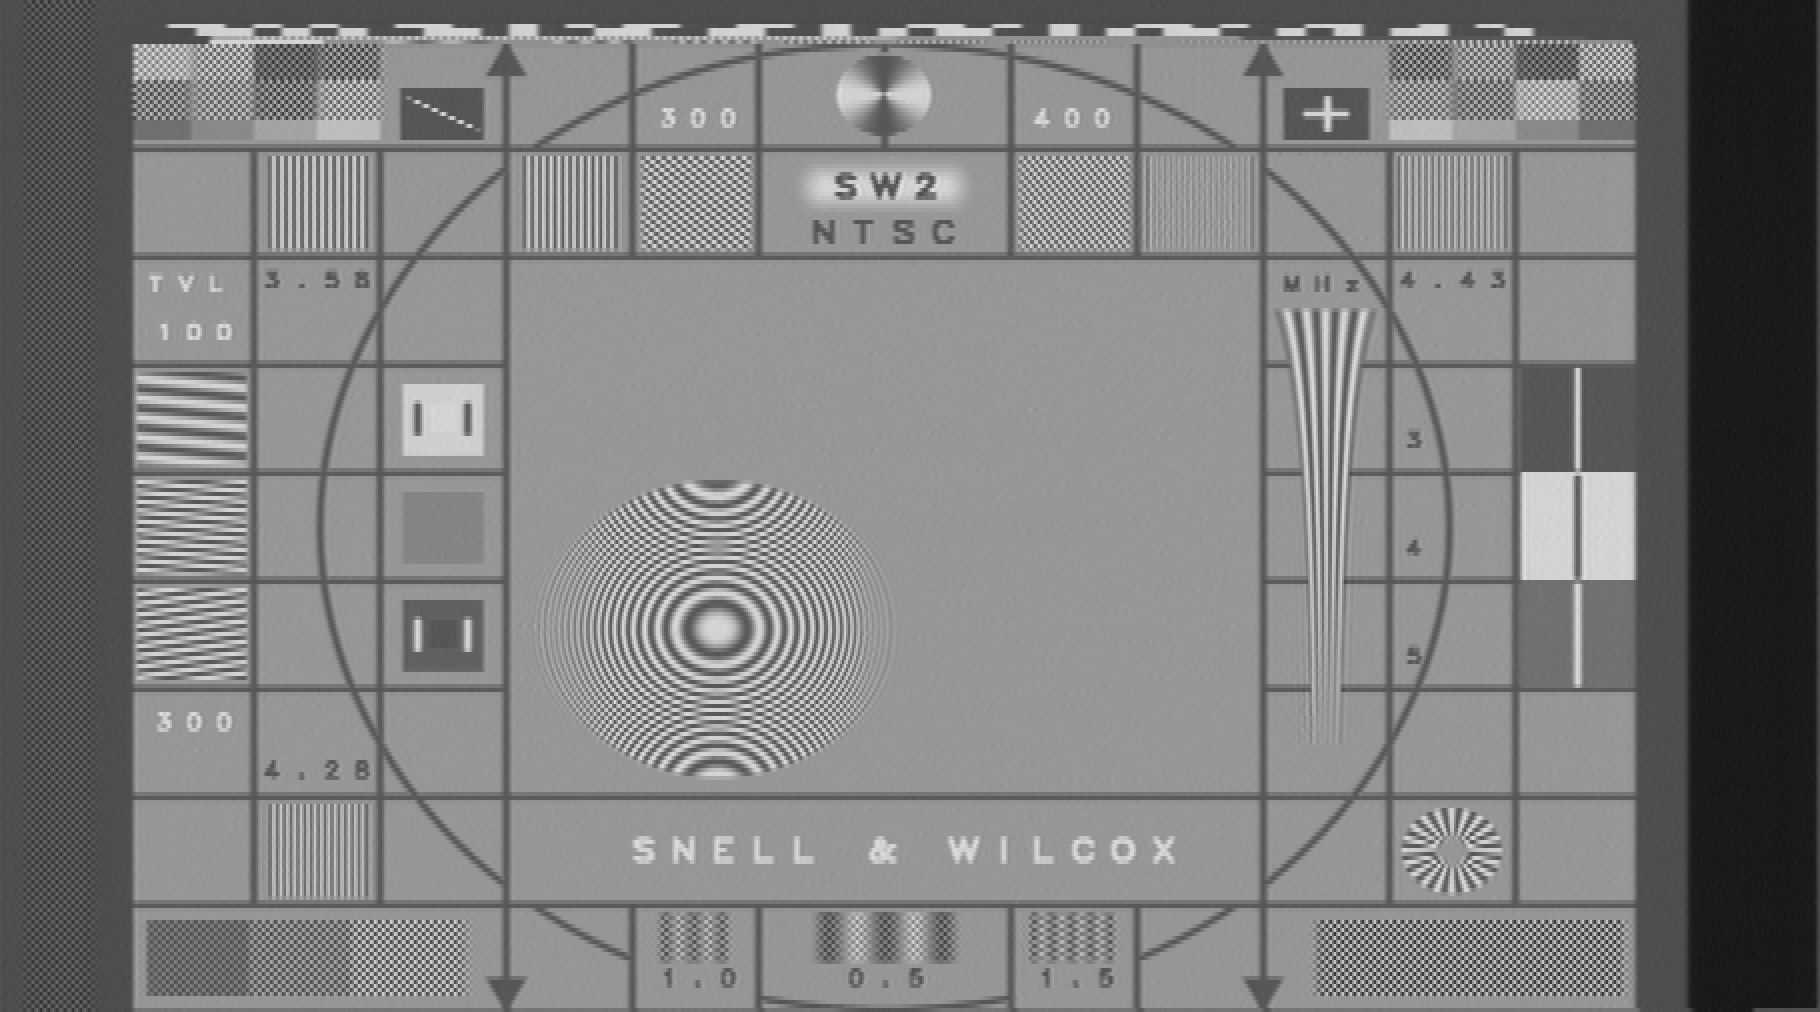

In [157]:
linesa, sfactor = downscale_field(output, lineinfo_tmpa)

reduced = (linesa - minn) / hz_ire_scale
lines16a = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16a, 910, len(lineinfo2)-1, hscale=2, vscale=4)

/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
(230230,)
uint8 (253, 910) (253, 910)


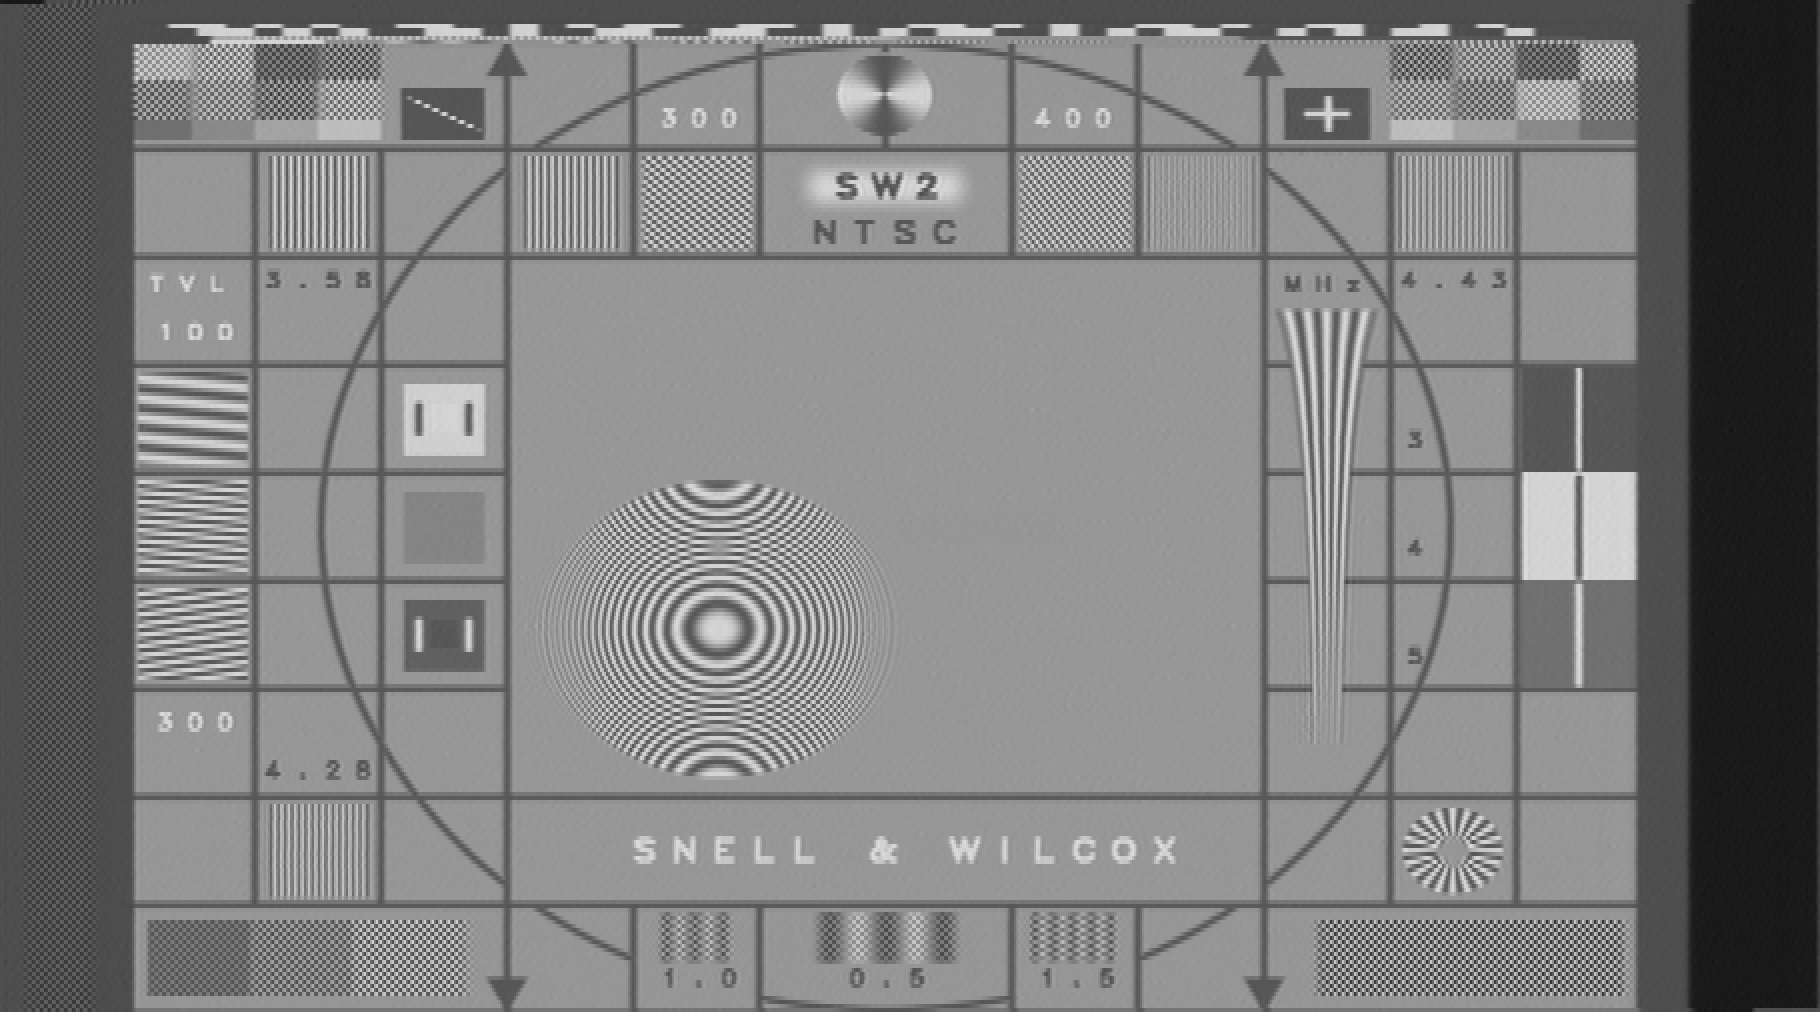

In [158]:
print(np.mean(finalsnr))
lines, sfactor = downscale_field(output, lineinfo2)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [275]:
lineinfo3[9]

(73741.012147804708, 76282.987504271412)

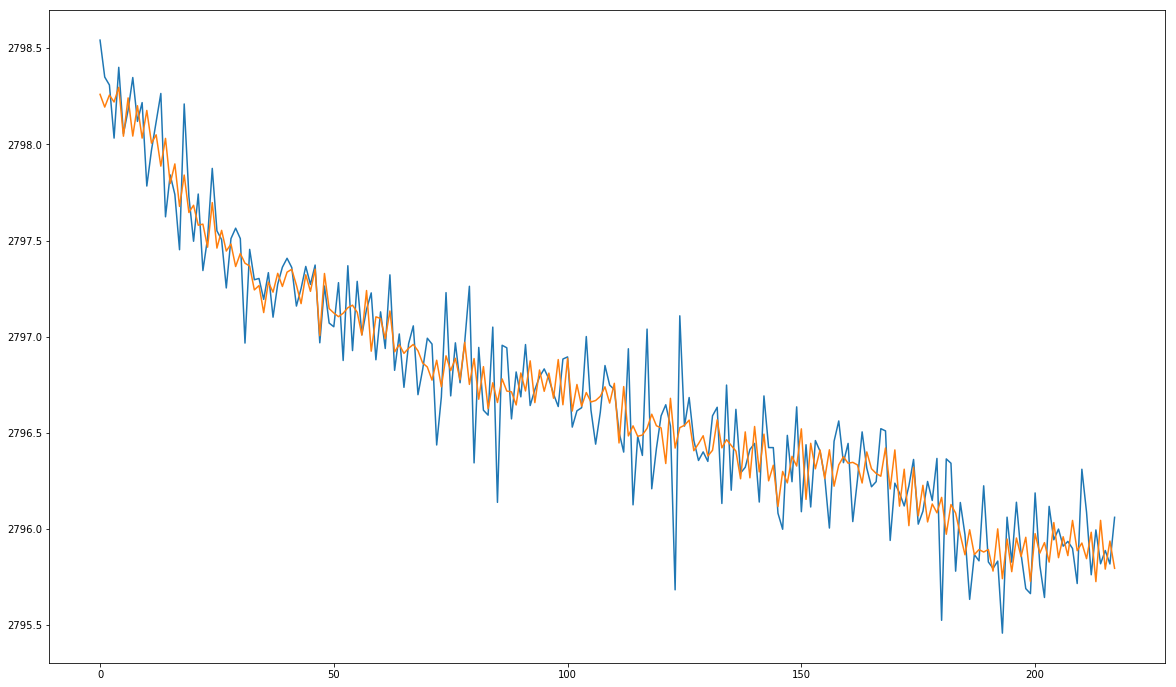

In [77]:
# tbc effectiveness check - line length.  lineinfo3 is pretty even
plt.plot(np.diff(lineinfo2[1:220]))
plt.plot(np.diff(lineinfo_tmpa[1:220]))

In [61]:
7.6+1.7

9.299999999999999

In [62]:
1.1*1.7

1.87

In [220]:
1.87+7.6

9.469999999999999

In [221]:
12.2-9.5

2.6999999999999993